In [1]:
import pandas as pd

train = pd.read_csv("https://raw.githubusercontent.com/developer-sdk/kaggle-python-beginner/master/datas/kaggle-titanic/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/developer-sdk/kaggle-python-beginner/master/datas/kaggle-titanic/test.csv")

def feature_engineering(df):
    # Sex
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})

    # Embarked
    df.Embarked.fillna('S', inplace=True)
    df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

    # Title
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.')
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Countess', 'Don','Dona', 'Dr', 'Jonkheer', 'Lady','Major', 'Rev', 'Sir'], 'Other')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs':3, 'Other':4})

    # Age
    meanAge = df[['Title', 'Age']].groupby(['Title']).mean()
    for index, row in meanAge.iterrows():
        nullIndex = df[(df.Title == index) & (df.Age.isnull())].index
        df.loc[nullIndex, 'Age'] = row[0]

    df['AgeCategory'] = pd.qcut(df.Age, 8, labels=range(1, 9))
    df.AgeCategory = df.AgeCategory.astype(int)

    # Cabin
    df.Cabin.fillna('N', inplace=True)
    df["CabinCategory"] = df["Cabin"].str.slice(start=0, stop=1)
    df["CabinCategory"] = df['CabinCategory'].map({ "N": 0, "C": 1, "B": 2, "D": 3, "E": 4, "A": 5, "F": 6, "G": 7, "T": 8 })

    # Fare
    df.Fare.fillna(0, inplace=True)
    df['FareCategory'] = pd.qcut(df.Fare, 8, labels=range(1, 9))
    df.FareCategory = df.FareCategory.astype(int)

    # SibSp, Parch
    df['Family'] = df['SibSp'] + df['Parch'] + 1
    df.loc[df["Family"] > 4, "Family"] = 5

    df['IsAlone'] = 1
    df.loc[df['Family'] > 1, 'IsAlone'] = 0

    # Ticket
    df['TicketCategory'] = df.Ticket.str.split()
    df['TicketCategory'] = [i[-1][0] for i in df['TicketCategory']]
    df['TicketCategory'] = df['TicketCategory'].replace(['8', '9', 'L'], '8')
    df['TicketCategory'] = pd.factorize(df['TicketCategory'])[0] + 1

    df.drop(['PassengerId', 'Ticket', 'Cabin', 'Fare', 'Name', 'Age', 'SibSp', 'Parch'], axis=1, inplace=True)

    return df

train = feature_engineering(train)
test = feature_engineering(test)

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Survived        891 non-null    int64
 1   Pclass          891 non-null    int64
 2   Sex             891 non-null    int64
 3   Embarked        891 non-null    int64
 4   Title           891 non-null    int64
 5   AgeCategory     891 non-null    int64
 6   CabinCategory   891 non-null    int64
 7   FareCategory    891 non-null    int64
 8   Family          891 non-null    int64
 9   IsAlone         891 non-null    int64
 10  TicketCategory  891 non-null    int64
dtypes: int64(11)
memory usage: 76.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Pclass          418 non-null    int64
 1   Sex             418 non-null    int64
 2   Embarked      

In [2]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
data = train.drop('Survived', axis = 1).values
target = train['Survived'].values

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.4, stratify=target, random_state=0)

In [6]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth = 5, oob_score=True, random_state=10)

In [7]:
rf.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=50,
                       oob_score=True, random_state=10)

In [8]:
prediction = rf.predict(x_test)

In [12]:
length = y_test.shape[0]
accuracy = accuracy_score(prediction, y_test)
print(f'총 {length}명 중 {accuracy * 100:.3f}% 정확도로 생존을 맞춤')

총 357명 중 82.913% 정확도로 생존을 맞춤


### 랜덤 포레스트 검증 #2

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

RF_classifier = RandomForestClassifier()

RF_paramgrid = {
    'max_depth' : [6, 8, 10, 15],
    'n_estimators': [50, 100, 300, 500, 700, 800, 900],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 7, 15, 30],
    'min_samples_leaf': [1, 15, 30, 60],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
    }

In [14]:
k_fold = StratifiedKFold(n_splits=5)

In [16]:
RF_classifiergrid = GridSearchCV(RF_classifier, param_grid = RF_paramgrid, \
                                 cv=k_fold, scoring="accuracy", n_jobs= -1, verbose=1)

In [17]:
RF_classifiergrid.fit(x_train, y_train)

Fitting 5 folds for each of 1792 candidates, totalling 8960 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 8, 10, 15], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 15, 30, 60],
                         'min_samples_split': [2, 7, 15, 30],
                         'n_estimators': [50, 100, 300, 500, 700, 800, 900]},
             scoring='accuracy', verbose=1)

In [18]:
rf = RF_classifiergrid.best_estimator_

In [19]:
print(RF_classifiergrid.best_score_)

0.8332921883265737


In [21]:
print(RF_classifiergrid.best_params_)

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [22]:
print(RF_classifiergrid.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       n_estimators=800)


In [23]:
import matplotlib.pyplot as plt
from pandas import Series

In [24]:
feature_importance = rf.feature_importances_

In [26]:
fi = Series(feature_importance, index=train.drop(['Survived'], axis=1).columns)

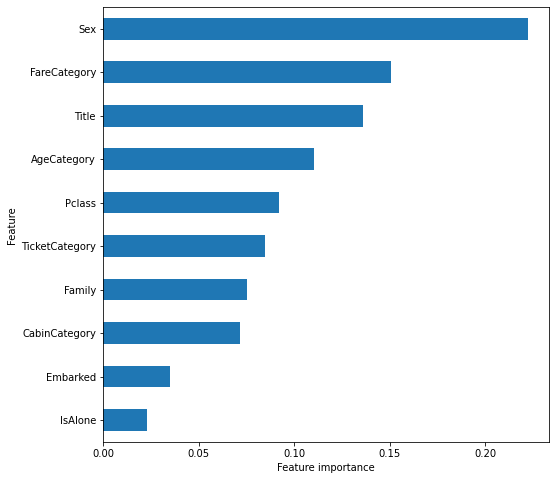

In [27]:
plt.figure(figsize=(8, 8))
fi.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [29]:
# data 분리 
data = train.drop('Survived', axis=1).values
target = train['Survived'].values
x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.4, stratify=target, random_state=0)

In [30]:
def ml_fit(model):
    model.fit(x_train, y_train)
    prediction = model.predict(x_valid)
    accuracy = accuracy_score(prediction, y_valid)
    print(model)
    print(f'총 {y_valid.shape[0]}명 중 {accuracy * 100:.3f}% 정확도로 생존을 맞춤')
    return model

In [31]:
model = ml_fit(RandomForestClassifier(n_estimators=100))
model = ml_fit(LogisticRegression(solver='lbfgs'))
model = ml_fit(SVC(gamma='scale'))
model = ml_fit(KNeighborsClassifier())
model = ml_fit(GaussianNB())
model = ml_fit(DecisionTreeClassifier())

RandomForestClassifier()
총 357명 중 78.992% 정확도로 생존을 맞춤
LogisticRegression()
총 357명 중 79.832% 정확도로 생존을 맞춤
SVC()
총 357명 중 81.513% 정확도로 생존을 맞춤
KNeighborsClassifier()
총 357명 중 77.031% 정확도로 생존을 맞춤
GaussianNB()
총 357명 중 73.389% 정확도로 생존을 맞춤
DecisionTreeClassifier()
총 357명 중 76.751% 정확도로 생존을 맞춤


=> 결과적으로 SVC가 제일 생존을 잘맞춤 

In [32]:
model = ml_fit(RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=5, oob_score=True, random_state=10))

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=50,
                       oob_score=True, random_state=10)
총 357명 중 82.913% 정확도로 생존을 맞춤


In [41]:
rf

RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       n_estimators=800)

In [47]:
prediction = rf.predict(test)

/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [48]:
submission = pd.read_csv("https://raw.githubusercontent.com/developer-sdk/kaggle-python-beginner/master/datas/kaggle-titanic/gender_submission.csv")

In [49]:
submission.Survived = prediction

In [50]:
submission.to_csv(r'titanic_submission_20220314_last.csv', index=False)